# CHARISMA - CHADA class development

## class chada

### __init__

In [1]:
import sys
!{sys.executable} -m pip install renishawWiRE
!{sys.executable} -m pip install specio

from renishawWiRE import WDFReader
from specio import specread

!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

!{sys.executable} -m pip install pandas
import pandas as pd

Define filename

In [2]:
import os
print(os.environ.get('JUPYTER_PATH'))
print(os.path.sep)
#please set environmental variable JUPYTER_PATH=Z:\WP Space\WP 4\Spectrum database\  
#(mine is of course different)

F:\nina\Ideaconsult\Projects\NMBP-35-CHARISMA\WP Space\WP 4\Spectrum database
\


In [3]:
#file = r"Z:\WP Space\WP 4\Spectrum database\Data from CSIC Renishaw Perkin\txt and wdf PET granza Renishaw Qontor\200218-17.wdf"
file = os.path.join(os.environ.get('JUPYTER_PATH'),"Data from CSIC Renishaw Perkin","txt and wdf PET granza Renishaw Qontor","200218-17.wdf")
file

'F:\\nina\\Ideaconsult\\Projects\\NMBP-35-CHARISMA\\WP Space\\WP 4\\Spectrum database\\Data from CSIC Renishaw Perkin\\txt and wdf PET granza Renishaw Qontor\\200218-17.wdf'

Choose reader via filename extension

In [4]:
readers = {'.spc': [specread, "print_info"], '.wdf': WDFReader}

In [5]:
ext = file[file.rfind("."):]

In [6]:
filename = file[file.rfind(os.path.sep)+2:]

In [7]:
filename

'00218-17.wdf'

In [8]:
reader = readers[ext]

Read file

In [9]:
s = reader(file)

In [10]:
counts = s.spectra
wavenumbers = s.xdata
if np.mean(np.diff(wavenumbers)) < 0:
    counts = np.flip(counts)
    wavenumbers = np.flip(wavenumbers)

In [11]:
s.__dict__.keys()

dict_keys(['file_obj', 'title', 'username', 'measurement_type', 'scan_type', 'laser_length', 'count', 'spectral_unit', 'xlist_type', 'xlist_unit', 'ylist_type', 'ylist_unit', 'point_per_spectrum', 'data_origin_count', 'capacity', 'application_name', 'application_version', 'xlist_length', 'ylist_length', 'accumulation_count', 'block_info', 'is_completed', 'debug', 'spectra', 'xdata', 'ydata', 'origin_list_header', 'xpos', 'ypos', 'zpos'])

#### Assign class variables from list

name  = 'varname'
value = 'something'

setattr(self, name, value) #equivalent to: self.varname= 'something'

print (self.varname)
#will print 'something'

In [12]:
meta = {
"native filename": filename,
"native format": ext,
"laser wavelength": s.laser_length,
"no. of accumulations": s.accumulation_count,
"spectral unit": s.spectral_unit,
"OEM software name": s.application_name,
"OEM software version": s.application_version,
"minimum wavelength": wavenumbers.min(),
"maximum wavelength": wavenumbers.max(),
"no of channels": len(counts),
"mean counts": counts.mean(),
"standard deviation": counts.std(),  
}

In [13]:
pd.DataFrame.from_dict(meta, orient='index', columns=['value'])

,value
native filename,00218-17.wdf
native format,.wdf
laser wavelength,514.501196
no. of accumulations,3
spectral unit,counts
OEM software name,WiRE
OEM software version,"[5, 2, 0, 9499]"
minimum wavelength,102.769531
maximum wavelength,3703.710938
no of channels,3190


### chada.plot

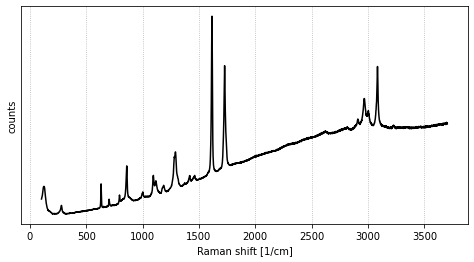

In [14]:
fig = plt.figure(figsize=[8,4])
plt.plot(wavenumbers, counts, 'k-')
plt.xlabel('Raman shift [1/cm]')
plt.ylabel(meta["spectral unit"])
plt.grid(axis='x', which='both', linestyle=':')
plt.yticks([])
plt.show()

chada.export

    with open('some_file.pkl', "wb") as fp:
        pickle.dump(fig, fp, protocol=4)

In [15]:
fig.savefig("output/chadafig_wdf.png", dpi=100)

chada.bands

In [16]:
!{sys.executable} -m pip install scipy
from scipy.signal import wiener, savgol_filter, find_peaks

prominence is important

In [17]:
s = savgol_filter(counts, 3, 2)
s -= s.min()
s /= s.max()
p = find_peaks(s,
    height=.1,
    threshold=None,
    distance=2,
    prominence=.05,
    width=None,
    wlen=None,
    rel_height=0.1,
    plateau_size=None)
p

(array([  15,  372,  540,  720,  873, 1137, 1231, 2383, 2504], dtype=int64),
 {'peak_heights': array([0.13884087, 0.15176563, 0.24281073, 0.19478539, 0.31354859,
         1.        , 0.74962085, 0.58373719, 0.74561054]),
  'prominences': array([0.06337517, 0.11965826, 0.17609609, 0.09061077, 0.17335685,
         0.78528155, 0.50452778, 0.13705602, 0.31490085]),
  'left_bases': array([   0,  145,  145,  586,  145,  145, 1170, 1278, 1278], dtype=int64),
  'right_bases': array([ 145,  386,  586,  770,  918, 1170, 1278, 2465, 2825], dtype=int64)})

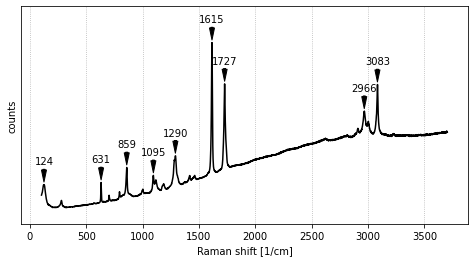

In [18]:
fig, ax = plt.subplots(figsize=[8,4])
plt.plot(wavenumbers, counts, 'k-')
for pos in p[0]:
    k_pos = wavenumbers[pos]
    band_y = counts[pos]
    ax.annotate(str(int(k_pos)), xy=(k_pos, band_y + counts.max()*.01),  xycoords='data',
                xytext=(k_pos, band_y + counts.max()*.1), textcoords='data',
                arrowprops=dict(facecolor='black', shrink=0.05, width=2,headwidth=5),
                horizontalalignment='center', verticalalignment='bottom', size=10
                )
plt.ylim(-.05, counts.max()+ counts.max()*.2)
plt.xlabel('Raman shift [1/cm]')
plt.ylabel(meta["spectral unit"])
plt.grid(axis='x', which='both', linestyle=':')
plt.yticks([])
plt.show()

In [19]:
P = pd.DataFrame(p[1])
P["peak pos [1/cm]"] = wavenumbers[p[0]]
cols = P.columns.tolist()

In [20]:
cols = [cols[-1], cols[0], cols[1], cols[2], cols[3]]
P = P.reindex(columns=cols)
P["left_bases"] = wavenumbers[P["left_bases"]]
P["right_bases"] = wavenumbers[P["right_bases"]]
#P = P.sort_values(by=["peak pos [1/cm]"])
P

,peak pos [1/cm],peak_heights,prominences,left_bases,right_bases
0,124.789062,0.138841,0.063375,102.769531,313.140625
1,631.638672,0.151766,0.119658,313.140625,650.863281
2,859.189453,0.242811,0.176096,313.140625,920.322266
3,1095.613281,0.194785,0.090611,920.322266,1159.972656
4,1290.794922,0.313549,0.173357,313.140625,1347.218750
5,1615.630859,1.000000,0.785282,313.140625,1655.207031
6,1727.773438,0.749621,0.504528,1655.207031,1783.171875
7,2966.837891,0.583737,0.137056,1783.171875,3046.316406
8,3083.742188,0.745611,0.314901,1783.171875,3382.882812


### class chag (chada group)

chag.build

chag.compare

chag.decompose